# This notebook contains the following analysis:

1. Neural Network for linear regression with cross validation grid search
2. Scikit-learn neural network regression with cross validation grid search
3. Neural network regression with optimal parameters Vs Scikit-learn


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import NeuralNet as nn
import functions as fx
import functions_NN as lrf
import os
import seaborn as sns
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

In [2]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-2/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

# Neural Network for linear regression with cross validation grid search

In [3]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)


# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# deleting the ones from the design matrix
#X_test  = np.delete(X_test, [0,1], axis=1) 
#X_train = np.delete(X_train, [0,1], axis=1)

# Training optimization parameters
epochs     = 1000
batch_size = int(len(z_train)/32)
n_features = X_train.shape[1] 
etavec     = np.logspace(-5, -2, 4)
lmbvec     = np.logspace(-5, -2, 4)
lmbvec[0]  = 0

# k-fold
k = 5
y_folds, x_folds = lrf.k_fold_reshaper(k,z_train,X_train,shuffle=True)

# Define activation functions
#activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
#activation = [lrf.relu, lrf.relu, lrf.nooutact]
activation = [lrf.leaky_relu, lrf.leaky_relu, lrf.nooutact]

#derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact_deriv]
#derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.nooutact_deriv]
derivative = [lrf.leaky_relu_deriv, lrf.leaky_relu_deriv, lrf.nooutact_deriv]

test_loss  = np.zeros((len(etavec), len(lmbvec)))
test_r2    = np.zeros((len(etavec), len(lmbvec)))
test_cost  = np.zeros((epochs, len(etavec), len(lmbvec)))
train_cost = np.zeros((epochs, len(etavec), len(lmbvec)))

for i, etas in enumerate(etavec):
    
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]

            # Creating the network object and defining the hyperparameters
            neural_net = nn.ANN(lmb = lmb, bias = 0.01, eta = etas, early_stop_tol = 1e-7,\
                                early_stop_nochange = 2000, mode = 'regression', regularization = 'l2')
            # Adding layers
            neural_net.add_layers(n_features=[n_features,20,20], n_neurons = [20,20,1] , n_layers=3)
            
            # Training the network
            neural_net.train(epochs, batch_size, xtrain, ytrain, activation, derivative \
                             , xtest, ytest, verbose = False)
            
            # performance metrics
            pred            = neural_net.feed_out(xtest, activation)
            test_loss[i,j] += fx.MSE(pred.ravel(), ytest.T)
            test_r2[i,j]   += fx.R2Score(pred.ravel(), ytest.T)
            
            cost_test, cost_train = neural_net.costs()
            test_cost[:,i,j]  += cost_test
            train_cost[:,i,j] += cost_train

# Average performance metrics
test_loss  = test_loss/k
test_r2    = test_r2/k
test_cost  = test_cost/k
train_cost = train_cost/k

In [4]:
bb = np.array(etavec)
ee = np.array(lmbvec)

bbin, eein = np.where(test_loss  == np.min(test_loss))
best_mbatch,best_epoch              = bb[bbin], ee[eein] 
bbin2, eein2 = np.where(test_r2 == np.max(test_r2))
best_mbatch2,best_epoch2            = bb[bbin2], ee[eein2] 

print('MSE best = ',best_mbatch,best_epoch)
print('R2 best = ',best_mbatch2,best_epoch2)

MSE best =  [0.01] [0.]
R2 best =  [0.01] [0.0001]


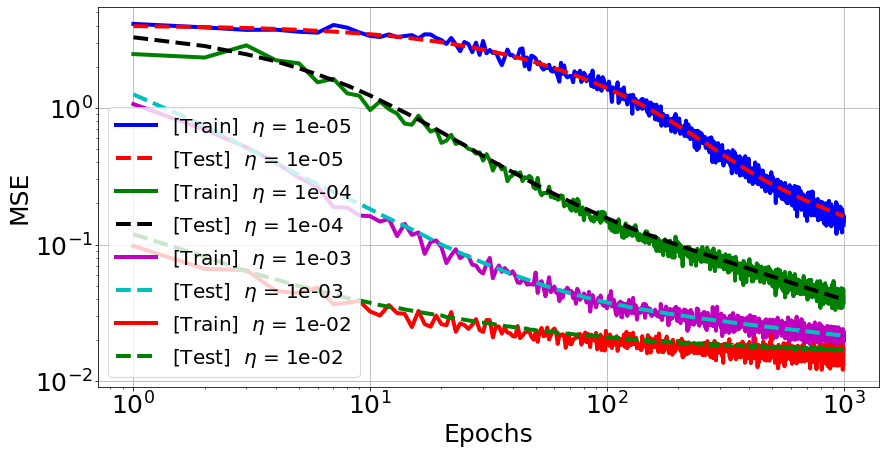

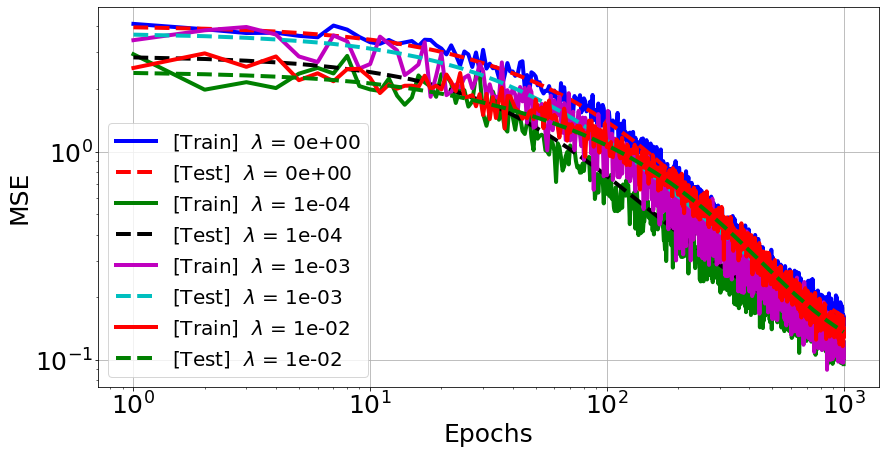

In [5]:
axis = np.arange(len(cost_train))+1
fig, ax = plt.subplots(figsize=(14,7))  
plt.loglog(axis, train_cost[:,0,0], 'b',linewidth=4,label="[Train] " + r" $\eta$ = %0.0e" %etavec[0])
plt.loglog(axis, test_cost[:,0,0],'r--',linewidth=4,label="[Test] " + r" $\eta$ = %0.0e" %etavec[0])
plt.loglog(axis, train_cost[:,1,0], 'g',linewidth=4,label="[Train] " + r" $\eta$ = %0.0e" %etavec[1])
plt.loglog(axis, test_cost[:,1,0],'k--',linewidth=4,label="[Test] " + r" $\eta$ = %0.0e" %etavec[1])
plt.loglog(axis, train_cost[:,2,0], 'm',linewidth=4,label="[Train] " + r" $\eta$ = %0.0e" %etavec[2])
plt.loglog(axis, test_cost[:,2,0],'c--',linewidth=4,label="[Test] " + r" $\eta$ = %0.0e" %etavec[2])
plt.loglog(axis, train_cost[:,3,0], 'r',linewidth=4,label="[Train] " + r" $\eta$ = %0.0e" %etavec[3])
plt.loglog(axis, test_cost[:,3,0],'g--',linewidth=4,label="[Test] " + r" $\eta$ = %0.0e" %etavec[3])
plt.legend(fontsize=25)
plt.grid()
plt.ylabel('MSE',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
ax.tick_params(axis='x', which='major', labelsize=25,pad=1)
ax.tick_params(axis='y', which='major', labelsize=25,pad=1)
ax.legend(loc='best',fontsize=20)
#save_fig('LinearReg_CV_eta_NN_sigmoid')
#save_fig('LinearReg_CV_eta_NN_relu')
save_fig('LinearReg_CV_eta_NN_elu')
plt.show()

axis = np.arange(len(cost_train))+1
fig, ax = plt.subplots(figsize=(14,7))  
plt.loglog(axis, train_cost[:,0,0], 'b',linewidth=4,label="[Train] " + r" $\lambda$ = %0.0e" %lmbvec[0])
plt.loglog(axis, test_cost[:,0,0],'r--',linewidth=4,label="[Test] " + r" $\lambda$ = %0.0e" %lmbvec[0])
plt.loglog(axis, train_cost[:,0,1], 'g',linewidth=4,label="[Train] " + r" $\lambda$ = %0.0e" %lmbvec[1])
plt.loglog(axis, test_cost[:,0,1],'k--',linewidth=4,label="[Test] " + r" $\lambda$ = %0.0e" %lmbvec[1])
plt.loglog(axis, train_cost[:,0,2], 'm',linewidth=4,label="[Train] " + r" $\lambda$ = %0.0e" %lmbvec[2])
plt.loglog(axis, test_cost[:,0,2],'c--',linewidth=4,label="[Test] " + r" $\lambda$ = %0.0e" %lmbvec[2])
plt.loglog(axis, train_cost[:,0,3], 'r',linewidth=4,label="[Train] " + r" $\lambda$ = %0.0e" %lmbvec[3])
plt.loglog(axis, test_cost[:,0,3],'g--',linewidth=4,label="[Test] " + r" $\lambda$ = %0.0e" %lmbvec[3])
plt.legend(fontsize=25)
plt.grid()
plt.ylabel('MSE',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
ax.tick_params(axis='x', which='major', labelsize=25,pad=1)
ax.tick_params(axis='y', which='major', labelsize=25,pad=1)
ax.legend(loc='best',fontsize=20)
#save_fig('LinearReg_CV_lamb_NN_sigmoid')
#save_fig('LinearReg_CV_lamb_NN_relu')
save_fig('LinearReg_CV_lamb_NN_elu')
plt.show()

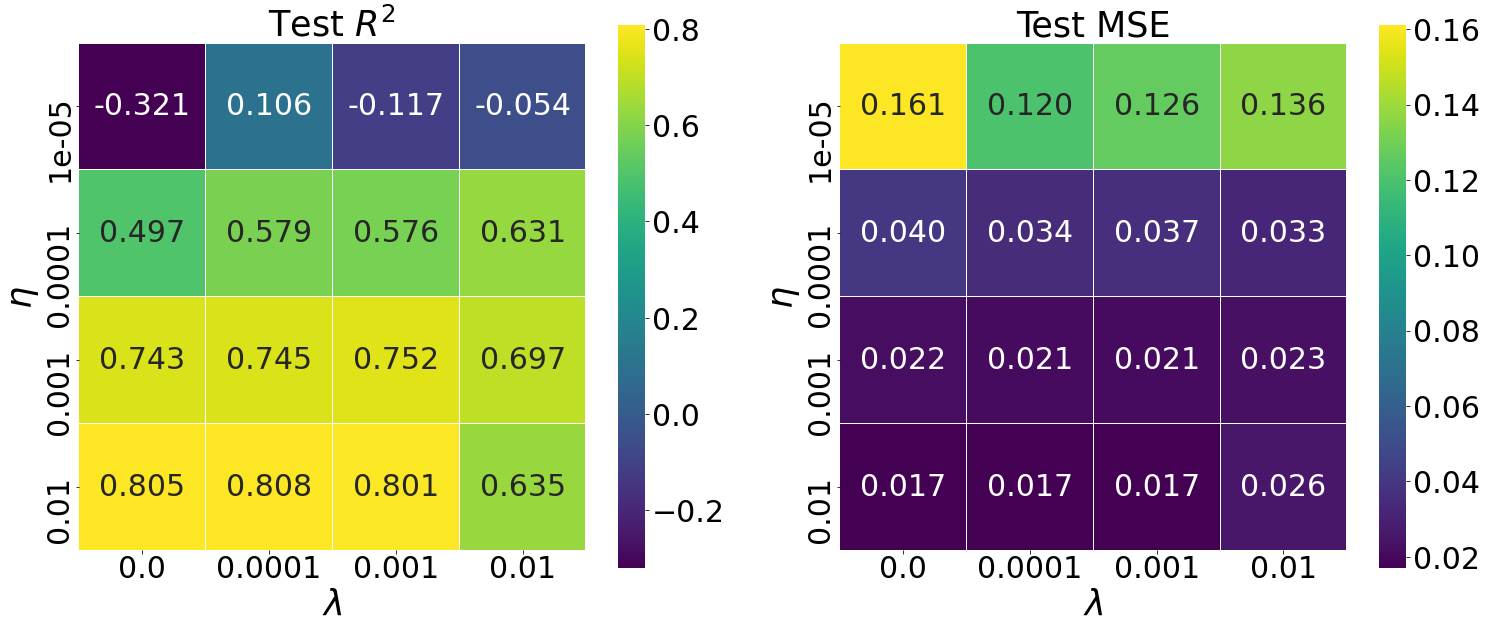

In [6]:
yticklabels = etavec
xticklabels = lmbvec

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(test_r2, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = r'Test $R^2$'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(test_loss, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test MSE'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
#save_fig('LinearReg_CV_eta_lamb_NN_sigmid')
#save_fig('LinearReg_CV_eta_lamb_NN_relu')
save_fig('LinearReg_CV_eta_lamb_NN_elu')
plt.show()

# Scikit-learn neural network regression with cross validation grid search

In [21]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# deleting the ones from the design matrix
#X_test  = np.delete(X_test, [0,1], axis=1) 
#X_train = np.delete(X_train, [0,1], axis=1)

# Training optimization parameters
epochs     = 1000
batch_size = int(len(z_train)/32)
n_features = X_train.shape[1] 
etavec     = np.logspace(-5, -2, 4)
lmbvec     = np.logspace(-5, -2, 4)
lmbvec[0]  = 0

# k-fold
k = 5
y_folds, x_folds = lrf.k_fold_reshaper(k,z_train,X_train,shuffle=True)

test_loss  = np.zeros((len(etavec), len(lmbvec)))
test_r2    = np.zeros((len(etavec), len(lmbvec)))
test_cost  = np.zeros((epochs, len(etavec), len(lmbvec)))
train_cost = np.zeros((epochs, len(etavec), len(lmbvec)))

for i, etas in enumerate(etavec):
    
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            ytrain = ytrain.ravel()
            ytest  = ytest.ravel()
            
            # Implement neural network
            #reg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20, 20),activation='logistic',batch_size=batch_size,learning_rate='constant',
            #                                          learning_rate_init=etas,alpha=lmb,max_iter=epochs,tol=1e-5,verbose=False)
            reg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20, 20),activation='relu',batch_size=batch_size,learning_rate='constant',
                                                      learning_rate_init=etas,alpha=lmb,max_iter=epochs,tol=1e-5,verbose=False)
            #reg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20, 20),activation='tanh',batch_size=batch_size,learning_rate='constant',
            #                                          learning_rate_init=etas,alpha=lmb,max_iter=epochs,tol=1e-5,verbose=False)
            reg = reg.fit(xtrain, ytrain)

            # performance metrics
            pred            = reg.predict(xtest)
            test_loss[i,j] += mean_squared_error(ytest, pred)
            test_r2[i,j]   += reg.score(xtest, ytest)

# Average performance metrics
test_loss  = test_loss/k
test_r2    = test_r2/k

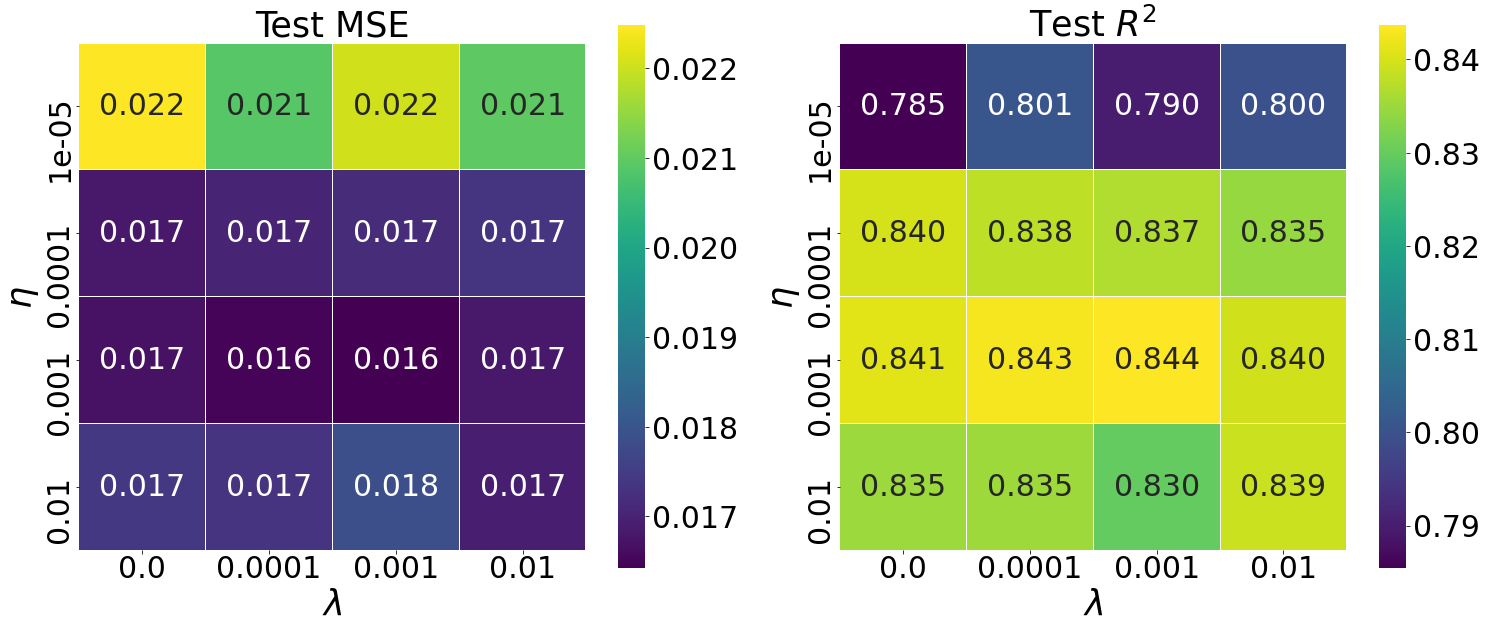

In [22]:
yticklabels = etavec
xticklabels = lmbvec

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(test_loss, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test MSE'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(test_r2, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = r'Test $R^2$'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
#save_fig('LinearReg_CV_eta_lamb_NN_sigmoid_SK')
save_fig('LinearReg_CV_eta_lamb_NN_relu_SK')
#save_fig('LinearReg_CV_eta_lamb_NN_tanh_SK')
plt.show()

# Neural network regression with optimal parameters Vs Scikit-learn

In [ ]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1.2, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# deleting the ones from the design matrix
#X_test  = np.delete(X_test, [0,1], axis=1) 
#X_train = np.delete(X_train, [0,1], axis=1)

# Training optimization parameters
epochs     = 1000
batch_size = int(len(z_train)/32)
n_features = X_train.shape[1] 
eta        = 0.01
lmb        = 1e-4

# Define activation functions
activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
#activation = [lrf.relu, lrf.relu, lrf.nooutact]
#activation = [lrf.leaky_relu, lrf.leaky_relu, lrf.nooutact]

derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact_deriv]
#derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.nooutact_deriv]
#derivative = [lrf.leaky_relu_deriv, lrf.leaky_relu_deriv, lrf.nooutact_deriv]


# Creating the network object and defining the hyperparameters
neural_net = nn.ANN(lmb = lmb, bias = 0.01, eta = etas, early_stop_tol = 1e-7,\
                                early_stop_nochange = 2000, mode = 'regression', regularization = 'l2')
# Adding layers
neural_net.add_layers(n_features=[n_features,20,20], n_neurons = [20,20,1] , n_layers=3)
            
# Training the network
neural_net.train(epochs, batch_size, X_train, z_train, activation, derivative \
                             , X_test, z_test, verbose = False)
            
# performance metrics
pred      = neural_net.feed_out(X_test, activation)
test_loss = fx.MSE(pred.ravel(), z_test.T)
test_r2   = fx.R2Score(pred.ravel(), z_test.T)


reg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20, 20),activation='logistic',
                                          batch_size=batch_size,learning_rate='constant',
                                          learning_rate_init=etas,alpha=lmb,max_iter=epochs,tol=1e-5,
                                          verbose=False)
reg = reg.fit(X_train, z_train.ravel())

# performance metrics
pred_sk      = reg.predict(X_test)
test_loss_sk = mean_squared_error(z_test.ravel(), pred_sk)
test_r2_sk   = reg.score(X_test, z_test.ravel())


In [ ]:
print('MSE NN TEST',test_loss)
print('MSE NN TEST Scikit',test_loss_sk)
print('R2 NN TEST',test_r2)
print('R2 NN TEST Scikit',test_r2_sk)

In [ ]:
# Plot the resulting fit beside the original surface
ppred_NN_test = pred.reshape(xx_test.shape)

#---------------------------------------------------------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
CS=ax.plot_surface(xx_test, yy_test, ppred_NN_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1=ax.scatter(xx_test, yy_test, zz_test, 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('x', fontsize = 25,labelpad=15)
plt.ylabel('y', fontsize = 25,labelpad=15)
plt.title("[Test] " + " MSE = %0.3f" %test_loss + 
          r", $\bf{R^2}$ = %0.3f"%test_r2, fontsize = 20, fontweight='bold')
fig.tight_layout()
save_fig('Noisy_NN_degree5')
plt.show()